In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import IPython
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras

## 1. Data Importing <br>
-importing stock prices <br>
-importing tickers for the SNP500 members

In [33]:
TARGET_VAR='Adj Close'
TICKER='AMZN'

STANDARDIZATION=True
STANDARDIZATION_WINDOW= 20 # That is roughly equal to 1 month of business days
MINMAXSCALLING= False


df=pd.read_csv('data/snp500_stock_prices.csv')
df.index=pd.to_datetime(df.Date)
df_og=df.copy(deep=True)

tickers=pd.read_csv("data/snp500_constituents.csv")
ticker_list=tickers.Symbol
# Tickers.head()

df=df.loc[df.Ticker==TICKER]
df=df.drop(columns='Ticker')
date_time=pd.to_datetime(df.pop('Date'))

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-11,793.659973,799.500000,789.510010,799.020020,799.020020,2992800.0
2017-01-12,800.309998,814.130005,799.500000,813.640015,813.640015,4873900.0
2017-01-13,814.320007,821.650024,811.400024,817.140015,817.140015,3791900.0
2017-01-17,815.700012,816.000000,803.440002,809.719971,809.719971,3670500.0
2017-01-18,809.500000,811.729980,804.270020,807.479980,807.479980,2354200.0


## 1.2 Quick Data Processing

In [34]:
def standardize(df_in, stand_window=STANDARDIZATION_WINDOW):
    df_stand=(df_in-df_in.rolling(stand_window).mean())/df_in.rolling(stand_window).std()
    df_stand=df_stand.dropna()
    return df_stand
    
# Make copy of pre-transofrmed data to revert standardization
df_og=df.copy(deep=True)
    
if STANDARDIZATION: 
    df=standardize(df)

if MINMAXSCALLING:
    minmax=MinMaxScaler(feature_range=(-1,1))
    cols=df.columns
    df=minmax.fit_transform(df)
    df=pd.DataFrame(data=df, columns=cols)

df.to_csv("data/data_clean.csv")

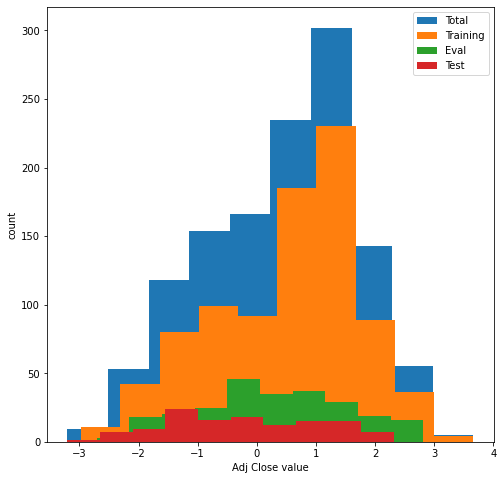

In [35]:
#Train-Test Split
# Break dataset in 0.7, 0.2, 0.1 (train, validation , test) sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

def plot_histo(target_var=TARGET_VAR, figsize = (8,8)):
    _ , ax = plt.subplots(1,1, figsize=figsize)

    ax.hist(df[target_var], label= "Total")
    ax.hist(train_df[target_var], label="Training")
    ax.hist(val_df[target_var], label='Eval')
    ax.hist(test_df[target_var], label="Test")

    ax.set_xlabel(f'{target_var} value')
    ax.set_ylabel(f'count')

    ax.legend( loc='upper right')

plot_histo()

## 2. Defining a WindowGenerator class <br> 
The object will format the dataset into staggered time windows of input-label pairs ready to be fed into tensorflow

In [36]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data
        self.train_df= train_df
        self.val_df= val_df
        self.test_df= test_df

        # Work out the label column indices
        self.label_columns= label_columns
        if label_columns is not None:
            if isinstance(label_columns, str):
                self.label_columns=[label_columns] #check if label_columns is a string (i.e. a single value) and turns it into a list if that is the case
            self.label_columns_indices= {name:i for i, name in  #maybe should be called column_indices...? - it is not used anywhere in the class
                                         enumerate(self.label_columns)}
        self.columns_indices= {name:i for i , name in 
                                enumerate (train_df.columns)}

        # Work out the window parameters 
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width +shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start=self.total_window_size-self.label_width
        self.labels_slice= slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
            
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])        

    def split_window(self, features):
        inputs= features[:,self.input_slice, :]
        labels= features[:, self.labels_slice,:]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:, self.columns_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

In [37]:
# Plotting function to visualize data samples

def plot(self, model=None, plot_col=TARGET_VAR, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.columns_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot  #Adding a function to all instances of a class


In [38]:
# Ouput Functions for Window Generator

def make_dataset(self, data, shuffle=True):
    data=np.array(data, dtype=np.float32)
    ds= tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=shuffle, 
        batch_size=32,)
    
    ds= ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property 
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df, shuffle=False)  #must keep the test dataset unshuffle to be able to reverse the rolling average normalization

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        result=next(iter(self.train))
        self._example = result
    return result

WindowGenerator.make_dataset = make_dataset
WindowGenerator.train= train
WindowGenerator.val= val
WindowGenerator.test=test
WindowGenerator.example= example


## 2.1 Initializing dataset generator

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['Adj Close']

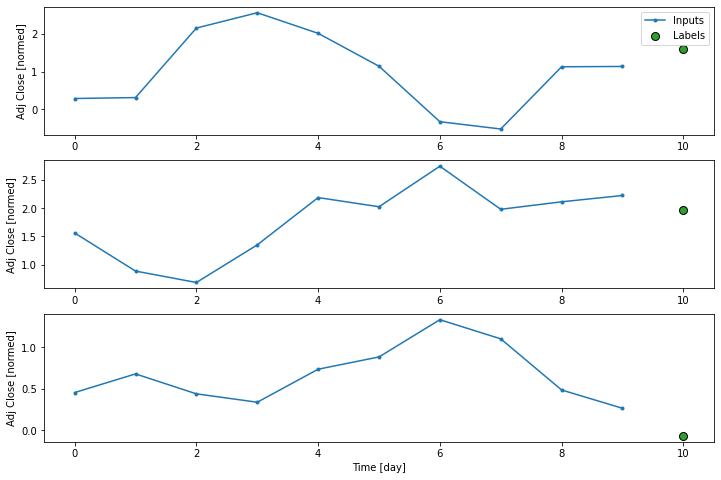

In [39]:
# Generating the sliding window dataset

INPUT_WIDTH=10
LABEL_WIDTH=1
SHIFT=LABEL_WIDTH
num_features= 1

OUT_STEPS=LABEL_WIDTH

multi_window= WindowGenerator(input_width=INPUT_WIDTH, label_width= LABEL_WIDTH, shift= SHIFT,  label_columns=TARGET_VAR)
multi_window.plot()

multi_window

## 3. Model Building

### 3.1 - Useful functions

In [40]:
# Function to compile and fit keras models 
MAX_EPOCHS=20

def compile_and_fit(model, window, patience=2, verbose=1):
    early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs= MAX_EPOCHS, 
                        validation_data=window.val, 
                        callbacks =[early_stopping], verbose=verbose)

    return history

In [41]:
# Function for ploting the prediction of a model to the true value
def plot_results(model, window=multi_window, same_axis=True, xmax=None):
    x=[]
    y=[]

    for element in window.test.as_numpy_iterator():
        x.append(element[0])
        y.append(element[1])

    x=np.concatenate(x)
    y=np.concatenate(y)

    y_pred=model.predict(x)[:,:,-1]
    y_true= y[:,:,-1]

    plt.scatter(y_pred, y_true, alpha=0.2)   
    plt.xlabel("y_pred")
    plt.ylabel("y_true")

    combined=np.append(y_true, y_pred)
    min = combined.min()
    max= combined.max()

    if same_axis:
     
        plt.xlim(min, max )
        plt.ylim(min, max)

        plt.axline((min, min), (max, max), alpha=0.25)
        plt.axline((0, min), (0, max), alpha=0.25, color='black')
        plt.axline((min, 0), (max, 0), alpha=0.25, color='black')

    else:

        plt.axline((min, min), (max, max), alpha=0.25)
        plt.axline((0, min), (0, max), alpha=0.25, color='black')
        plt.axline((min, 0), (max, 0), alpha=0.25, color='black')
        
    if xmax:
        plt.xlim(min, xmax )
        plt.ylim(min, xmax)


### 3.2 - Models

Model 1 - Baseline model - simply returning the last step of the input as the output (assumes stock price is the same as the day prior)

8/8 [==============================] - 0s 1ms/step - loss: 0.8891 - mean_absolute_error: 0.6878


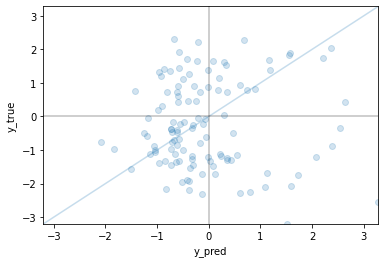

In [42]:
# Baseline model - simply returning the last step of the input as the output (assumes stock price is the same as the day prior)

class MultiStepLastBaseline (tf.keras.Model):
    def call(self, inputs): 
        return tf.tile(inputs[:,-1:,:], [1, OUT_STEPS, 1])

last_baseline= MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), 
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

plot_results(last_baseline, same_axis=True)

Input shape: (32, 10, 6)
Label shape: (32, 1, 1)
Output shape: (32, 1, 1)
8/8 [==============================] - 0s 2ms/step - loss: 0.5305 - mean_absolute_error: 0.5468


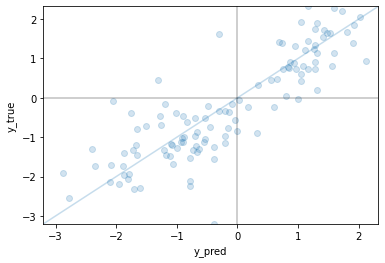

In [43]:
# Simple feed-forward neural network
linear_model = tf.keras.Sequential([
    # Input
    keras.layers.Input(shape=(len(multi_window.input_indices), len(multi_window.columns_indices))),
    keras.layers.Flatten(name='flat'),
    # Hidden layer (optional)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    # Output
    keras.layers.Dense(OUT_STEPS*num_features,
                        kernel_initializer = tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(linear_model, multi_window, patience=5)

IPython.display.clear_output()

current_window=multi_window
current_model= linear_model
print('Input shape:', current_window.example[0].shape)
print('Label shape:', current_window.example[1].shape)
print('Output shape:', current_model(current_window.example[0]).shape)

multi_val_performance['Linear'] = linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = linear_model.evaluate(multi_window.test, verbose=0)

plot_results(linear_model, multi_window, same_axis=True)

Model 2 - Feed-forward neural network with deep learning

Input shape: (32, 10, 6)
Label shape: (32, 1, 1)
Output shape: (32, 1, 1)


8/8 [==============================] - 0s 5ms/step - loss: 0.4756 - mean_absolute_error: 0.5277


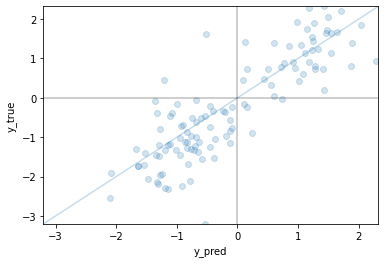

In [44]:
# Feed-forward neural network with deep learning
linear_model = tf.keras.Sequential([
    # Input
    keras.layers.Input(shape=(len(multi_window.input_indices), len(multi_window.columns_indices))),
    keras.layers.Flatten(name='flat'),
    # Hidden layer (optional)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    # Output
    keras.layers.Dense(OUT_STEPS*num_features,
                        kernel_initializer = tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(linear_model, multi_window, patience=4)

IPython.display.clear_output()

current_window=multi_window
current_model= linear_model
print('Input shape:', current_window.example[0].shape)
print('Label shape:', current_window.example[1].shape)
print('Output shape:', current_model(current_window.example[0]).shape)

multi_val_performance['Linear'] = linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = linear_model.evaluate(multi_window.test, verbose=0)

plot_results(linear_model, multi_window, same_axis=True)

Model 3 - Convolutional Neural Net

8/8 [==============================] - 0s 1ms/step - loss: 0.4202 - mean_absolute_error: 0.4886


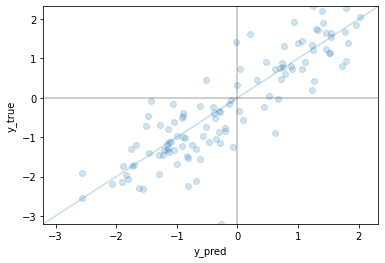

In [45]:
CONV_WIDTH=3
# Simple convolutional neural net on the last 3 inputs
conv_model = keras.Sequential([

    keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),      
    keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)), 
    keras.layers.Dense(OUT_STEPS*num_features, 
                        kernel_initializer= tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])

])

history = compile_and_fit(conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = conv_model.evaluate(multi_window.test, verbose=0)

plot_results(conv_model, same_axis=True)

Model 4 - LSTM model

8/8 [==============================] - 0s 2ms/step - loss: 0.4164 - mean_absolute_error: 0.4815


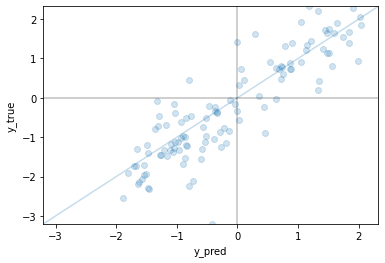

In [46]:
lstm_model = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(OUT_STEPS*num_features, 
                        kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

plot_results(lstm_model, same_axis=True)

Model 5 - Autoregressive Model

8/8 [==============================] - 0s 2ms/step - loss: 0.4176 - mean_absolute_error: 0.4813


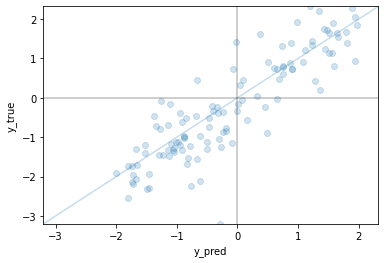

In [47]:
# Autoregressive model - only useful if trying to predict multiple timepoints in the future
num_features=6

# Building the model
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps= out_steps
        self.units= units
        self.lstm_cell = keras.layers.LSTMCell(units)
        self.lstm_rnn= keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense= keras.layers.Dense(num_features)

feedback_model=FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)

    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions=[]
    prediction, state= self.warmup(inputs)
    predictions.append(prediction)

    for n in range(1, self.out_steps):
        x=prediction
        x, state = self.lstm_cell(x, states=state,
                                    training=training)
        prediction= self.dense(x)
        predictions.append(prediction)

    predictions=tf.stack(predictions)
    predictions= tf.transpose(predictions, [1,0,2])
    return predictions

FeedBack.call = call

# Compiling and running the model

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
# Multi_window.plot(feedback_model)

plot_results(feedback_model, same_axis=True)

Model 5 - Deep Convolutional Net 

8/8 [==============================] - 0s 4ms/step - loss: 0.4556 - mean_absolute_error: 0.5086


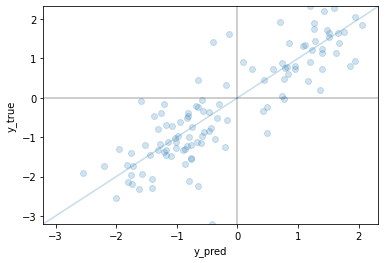

In [48]:
# Deep convolutional neural net
# The model isn't particularly appropriate for a time window so small, 
# But the single-layer conv net above was performing quite well so I wondered if adding depth might improve performance

CONV_WIDTH= multi_window.input_width

deep_conv_model = keras.Sequential([
    # Input layer
    keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding='same'), 

    # Hidden layers
    keras.layers.Conv1D(132, activation='relu', kernel_size=(CONV_WIDTH),  padding='same'), 
    keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH),  padding='same'),    
    keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH),  padding='same'), 
    keras.layers.Conv1D(16, activation='relu', kernel_size=(CONV_WIDTH),  padding='same'), 
    keras.layers.Conv1D(8, activation='relu', kernel_size=(CONV_WIDTH),  padding='same'), 
    keras.layers.Flatten(),
    
    # Output layer
    keras.layers.Dense(OUT_STEPS*num_features, 
                        kernel_initializer= tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])

])

history = compile_and_fit(deep_conv_model, multi_window, patience=2)

IPython.display.clear_output()

multi_val_performance['New_conv'] = deep_conv_model.evaluate(multi_window.val)
multi_performance['New_conv'] = deep_conv_model.evaluate(multi_window.test, verbose=0)


plot_results(deep_conv_model, same_axis=True)

Model 6 - Deep LSTM Model

8/8 [==============================] - 0s 5ms/step - loss: 0.4544 - mean_absolute_error: 0.5034


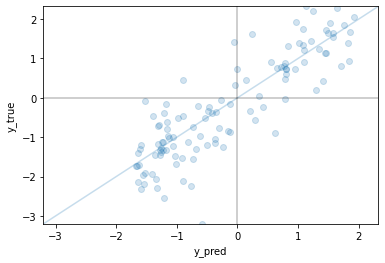

In [49]:
# Same as the convolutional net above, I wanted to know if adding depth to the LSTM model would improve performance
# Doesn't seem so unfortunately

deep_lstm_model = keras.Sequential([
    # Input layer
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.05),

    # Hidden layer
    keras.layers.LSTM(32, return_sequences=True),    
    keras.layers.LSTM(32, return_sequences=True),    
    keras.layers.LSTM(32, return_sequences=True),    
    keras.layers.LSTM(32, return_sequences=False),

    # Output layer
    keras.layers.Dense(OUT_STEPS*num_features, 
                        kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(deep_lstm_model, multi_window, patience=2)

IPython.display.clear_output()

multi_val_performance['new_LSTM'] = deep_lstm_model.evaluate(multi_window.val)
multi_performance['new_LSTM'] = deep_lstm_model.evaluate(multi_window.test, verbose=0)

plot_results(deep_lstm_model, same_axis=True)

Model 7 - Ensemble Model <br>
Pooling the prediction of the different models and performing deep learning

In [50]:
# Compile and fit function for the ensemble model 
# I needed to be modify the original to allow the input to be the predictions of the level 0 models 
# Instead of the time windows data 

MAX_EPOCHS=20

def ensemble_compile_and_fit(model, x, y, eval_data, patience=2, verbose=1):
    early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(x=x, y=y, epochs= MAX_EPOCHS, 
                        validation_data=eval_data, 
                        callbacks =[early_stopping], verbose=verbose)

    return history

def get_numpy(window_dataset):
    """
    Turn window generator into numpy array
    Used so that dataset don't get shuffled between training of the different models for the ensemble model
    """
    x=[]
    y=[]

    for element in window_dataset.as_numpy_iterator():
        x.append(element[0])
        y.append(element[1])

    x=np.concatenate(x)
    y=np.concatenate(y)

    return x, y



In [51]:
# ENSEMBLE MODEL

# TRAINING LEVEL 0 MODELS

print("Training Level 0")
models= [ linear_model, conv_model, lstm_model] #level 0 models
window=multi_window
CONV_WIDTH=3

train_x, train_y =get_numpy(window.train)
val_x, val_y =get_numpy(window.val)
test_x, test_y =get_numpy(window.test)

train_pred=[]
val_pred=[]
test_pred=[]

trained_models=[]

for model in models:
    ensemble_compile_and_fit(model, x=train_x, y=train_y, eval_data= [val_x, val_y], verbose=0)

    train_pred.append(model.predict(train_x)[:,:,-1])
    val_pred.append(model.predict(val_x)[:,:,-1])
    test_pred.append(model.predict(test_x)[:,:,-1])

train_pred =np.hstack(train_pred)
val_pred =np.hstack(val_pred)
test_pred =np.hstack(test_pred)

# TRAINING LEVEL 1 MODEL (META-MODEL)

print("Training Level 1")
ensemble_input_shape= train_pred.shape[1]
layer_width= 32

ensemble = tf.keras.Sequential([
    # Input
    keras.layers.Input(shape=(ensemble_input_shape)),

    # Hidden layer (optional)
    keras.layers.Dense(layer_width, activation='relu'),
    keras.layers.Dropout(0.1),

    # Output
    keras.layers.Dense(OUT_STEPS*num_features,
                        kernel_initializer = tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

ensemble_compile_and_fit(ensemble, train_pred, train_y, eval_data= [val_pred, val_y], patience=10)
IPython.display.clear_output()

print("EVALUATING:")
ensemble.evaluate(test_pred, test_y)
    

EVALUATING:
4/4 [==============================] - 0s 2ms/step - loss: 0.4255 - mean_absolute_error: 0.4891


[0.4254610538482666, 0.4890891909599304]

### 3.3 - Comparing Models

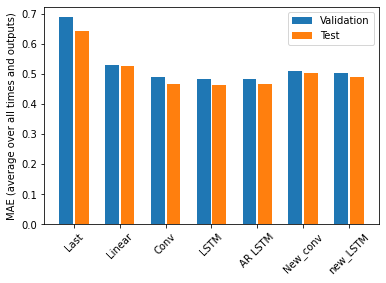

In [54]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

plt.savefig(f'images/model_comparison_{TICKER}.png', facecolor= 'white', bbox_inches='tight')

## Final Results

In [56]:
# Reverting the rolling average standardization
df2=df_og.copy(deep=True)

pred= lstm_model.predict(test_x)[:,:,-1]
pred=np.reshape(pred, pred.shape[0])

dft = test_df.iloc[-pred.shape[0]:]

# Extract rolling mean and standard dev from original data
df_mean =df2.rolling(STANDARDIZATION_WINDOW).mean().dropna()
stdev =df2.rolling(STANDARDIZATION_WINDOW).std().dropna()

# Keep only index in test set
df_mean= df_mean.loc[df_mean.index.isin(dft.index), TARGET_VAR]
stdev = stdev.loc[stdev.index.isin(dft.index),  TARGET_VAR]

actual_pred = (pred*stdev)+df_mean
true_value= df2.loc[df2.index.isin(dft.index), TARGET_VAR]


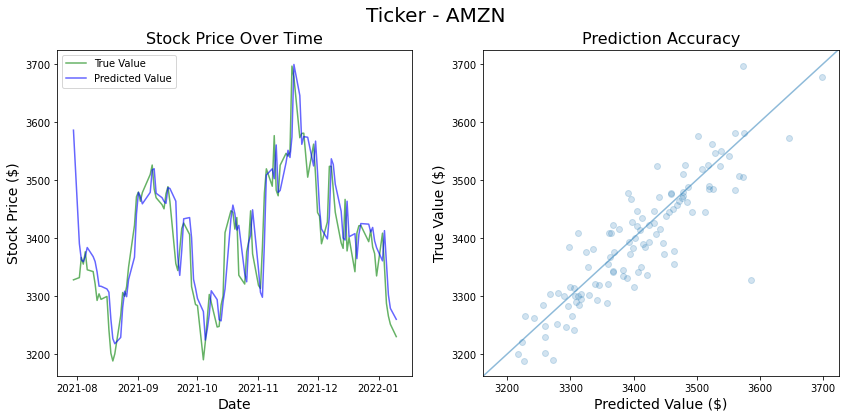

In [57]:
# Plotting the results
def make_plots(y_pred, y_true, save_plot=False): 
    #font size
    large_font = 16
    medium_font=14  

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    # TITLE
    fig.suptitle(f'Ticker - {TICKER}', fontsize=20)
    
    # LEFT PLOT
    axes[0].plot( dft.index, true_value, color='green', alpha=0.6, label="True Value")
    axes[0].plot( dft.index, actual_pred, color='blue', alpha=0.6, label="Predicted Value")
    axes[0].set_ylabel("Stock Price ($)", fontsize= medium_font)
    axes[0].set_xlabel("Date", fontsize= medium_font)
    axes[0].legend(loc='upper left')
    axes[0].set_title('Stock Price Over Time', fontdict={'fontsize': large_font, 'fontweight': 'medium'})

    # RIGHT PLOT
    axes[1].scatter(y_pred, y_true, alpha=0.2)   
    axes[1].set_xlabel("Predicted Value ($)", fontsize= medium_font)
    axes[1].set_ylabel("True Value ($)", fontsize= medium_font)
    axes[1].set_title('Prediction Accuracy', fontdict={'fontsize': large_font, 'fontweight': 'medium'})

    # Make sure both axis are the same
    combined=np.append(y_true, y_pred)
    min = combined.min()
    max= combined.max()
    axes[1].axline((min, min), (max, max), alpha=0.5)


    if save_plot:
        fig.savefig(f'images/{TICKER}.png', facecolor= 'white', bbox_inches='tight')


make_plots(actual_pred, true_value, save_plot=True)